In [1]:
# necessary imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras

In [4]:
# setting up paths for train/valid/test
train_dir = pathlib.Path('/Users/elliotttrott/Desktop/CTscns2C/train')
val_dir = pathlib.Path('/Users/elliotttrott/Desktop/CTscns2C/val')
test_dir = pathlib.Path('/Users/elliotttrott/Desktop/CTscns2C/test')

# show the quantity of images in the set a different way
train_image_count = len(list(train_dir.glob('*/*.png')))
train_image_count

353

In [5]:
# setting up batch/image sizes 
batch_size = 32
image_width = 224
image_height = 224

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    #validation_split=0.5,
    #subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 567 files belonging to 2 classes.
Found 25 files belonging to 2 classes.
Found 68 files belonging to 2 classes.


Have already seen the brekadown of data by categry

In [6]:
## naming classes

class_names = ["Cancerous",
"normal"]

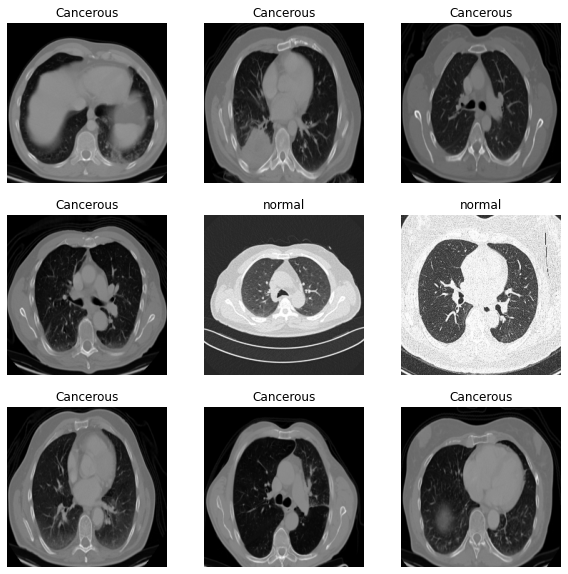

In [7]:
# plotting some examples again
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [8]:
# importing a pretrained model MobileNet, using imagenet weights (these will be changed later)
base_modelM = keras.applications.MobileNetV3Small(input_shape=(image_width, image_height, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

In [9]:
# Freeze certain layers that we want untrainable
base_modelM.trainable = False
base_modelM.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [10]:
# some data augmentation here as currently we are not working with a lage data set

data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [12]:
num_classes = len(class_names)

inputs = keras.Input(shape=(image_width, image_height, 3))
#x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_modelM(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x) # last layer softmax 
model = keras.Model(inputs, outputs)

In [14]:
# need to define the acccuracy for the metrics
import keras.backend as K

# defing f1 score using predictions

def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
METRICS = [
      'accuracy',f1_score
]

In [16]:
# compiling model metrics = accuracy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[METRICS])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 1,532,018
Trainable params: 2,050
Non-trainable

Model summary is featured above -- 1,532,018 total parameters

In [17]:
# performing 40 epochs at first
initial_epochs = 40

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

# code for training the model over the training data using the validation also
history = model.fit(train_ds, 
          validation_data=val_ds,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/40
18/18 [==============================] - 7s 251ms/step - loss: 0.2961 - accuracy: 0.8765 - f1_score: 0.6162 - val_loss: 0.1225 - val_accuracy: 0.9600 - val_f1_score: 0.1481
Epoch 2/40
18/18 [==============================] - 4s 222ms/step - loss: 0.0758 - accuracy: 0.9735 - f1_score: 0.6128 - val_loss: 0.0951 - val_accuracy: 0.9600 - val_f1_score: 0.1481
Epoch 3/40
18/18 [==============================] - 4s 223ms/step - loss: 0.0477 - accuracy: 0.9877 - f1_score: 0.6162 - val_loss: 0.0947 - val_accuracy: 0.9600 - val_f1_score: 0.1481
Epoch 4/40
18/18 [==============================] - 4s 225ms/step - loss: 0.0389 - accuracy: 0.9824 - f1_score: 0.6178 - val_loss: 0.0919 - val_accuracy: 0.9600 - val_f1_score: 0.1481
Epoch 5/40
18/18 [==============================] - 4s 226ms/step - loss: 0.0339 - accuracy: 0.9894 - f1_score: 0.6180 - val_loss: 0.1017 - val_accuracy: 0.9600 - val_f1_score: 0.1481


looks to be very accurate over the training data

In [18]:
initial_epochs = len(history.history['accuracy'])

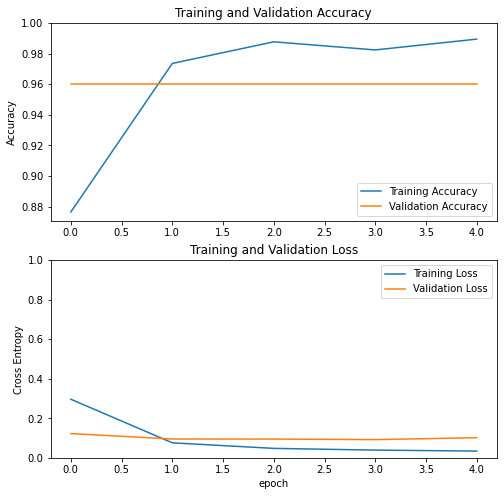

In [19]:
# plotting the metric accuracy over epochs 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# doing the same for the loss function
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

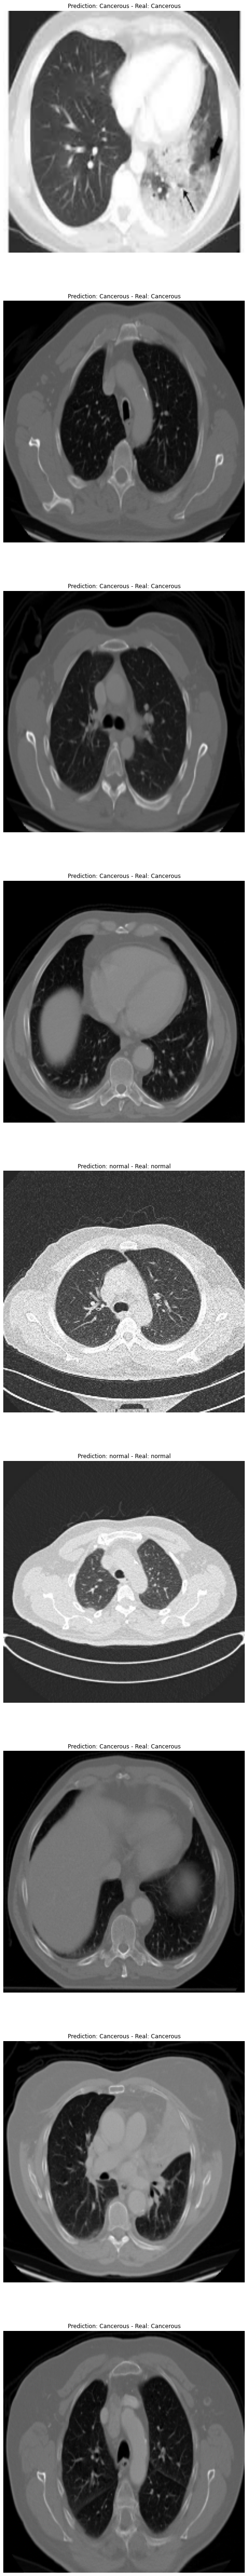

In [20]:
# make a prediction and compare to the real on the same plot - image taken from the test data set
plt.figure(figsize=(10, 100))
for images, labels in test_ds.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Prediction: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')

Prediction is correct from these images. Test larger batches to judge accuracy?

In [21]:
test_ds_unbatch = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=None,
    shuffle=False,
    image_size=(image_height, image_width),
    batch_size=image_height,
)
images = list(test_ds_unbatch.map(lambda x, y: x))
labels = list(test_ds_unbatch.map(lambda x, y: y))

Found 68 files belonging to 2 classes.


In [22]:
# make predictions over the test data
y_test = np.concatenate([y for x, y in test_ds_unbatch], axis=0)
prediction = model.predict(test_ds_unbatch)
pred = np.argmax(prediction,axis=1)
print(pred)    
from sklearn.metrics import accuracy_score

accuracy_score(pred,y_test) # show the accuracy

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


0.9852941176470589

Accuracy of 98.5% over the test data, this model appears to be highly accurate at determining whether an individial is displaying signs of solid tumours. - this is predictive accuracy, which is slightly different

In [23]:
model.evaluate(test_ds)

3/3 [==============================] - 1s 133ms/step - loss: 0.0599 - accuracy: 0.9853 - f1_score: 0.4889


[0.059926293790340424, 0.9852941036224365, 0.48888885974884033]

In [ ]:
# fine tune this further?

In [24]:
# plot a confusion matrix 

# imports
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(pred, y_test)
confusion_matrix = confusion_matrix.astype(int)

In [25]:
# more imports 
import plotly.figure_factory as ff
# need to pip install in terminal along with cufflinks

# defining the confusion plot
def plot_confusion_matrix(z,x,y):
    x = x
    y = x[::-1].copy()
    z = z[::-1]
    # change each element of z to string - annotate
    z_text = [[str(y) for y in x] for x in z[::-1]]

    # figure set up
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Matriz de Confusão</b></i>',
                      #xaxis = dict(title='x'),
                      #yaxis = dict(title='x')
                     )

    # x axis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Valor Previsto",
                            xref="paper",
                            yref="paper"))

    # y axis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Valor Real",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins 
    fig.update_layout(margin=dict(t=50, l=200))
    fig.update_yaxes(type='category')
    # add colour
    fig['data'][0]['showscale'] = True
    fig.show()

In [26]:
import plotly.express as px

z = confusion_matrix
fig = px.imshow(z)
fig.show()
# plot the confusion matrix

In [27]:
z = confusion_matrix[:10,:10]
fig = px.imshow(z)
fig.show()

In [30]:
base_modelM.trainable = True

# Fine-tuning
fine_tune_at = 100

# freezing some layerss
for layer in base_modelM.layers[:fine_tune_at]:
    layer.trainable =  False

In [31]:
# setting the base LR
base_learning_rate = 0.0001
# compiling model again
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[METRICS])
# to avoid overfitting use a lower LR

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 1,532,018
Trainable params: 1,406,434
Non-train

In [32]:
# fine tune from the point at which model stopped previously
fine_tune_epochs = 4
total_epochs = initial_epochs + fine_tune_epochs

# early stopping 
early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

# train the model again over just the training data, using val data
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[early_stop])

Epoch 5/9
18/18 [==============================] - 12s 434ms/step - loss: 0.0298 - accuracy: 0.9877 - f1_score: 0.6166 - val_loss: 0.1109 - val_accuracy: 0.9600 - val_f1_score: 0.1481
Epoch 6/9
18/18 [==============================] - 7s 396ms/step - loss: 0.0229 - accuracy: 0.9912 - f1_score: 0.6166 - val_loss: 0.0979 - val_accuracy: 0.9600 - val_f1_score: 0.1481
Epoch 7/9
18/18 [==============================] - 8s 441ms/step - loss: 0.0184 - accuracy: 0.9929 - f1_score: 0.6159 - val_loss: 0.1240 - val_accuracy: 0.9600 - val_f1_score: 0.1481


Accuracy has been boosted by, fine tuning appears to have worked

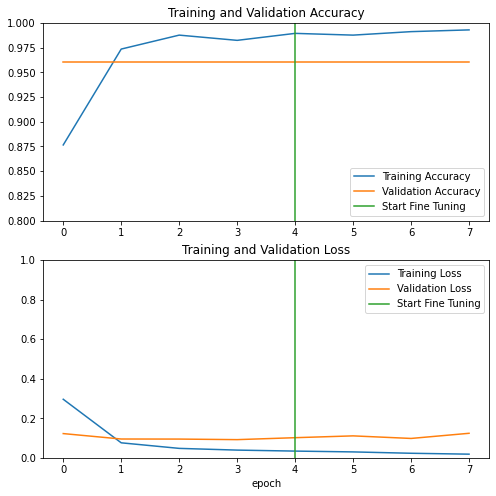

In [33]:
# plotting new graphs for accuracy and loss with fine tuninng included
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
# evaluate over the test data for metric of accuracy
model.evaluate(test_ds)

3/3 [==============================] - 1s 132ms/step - loss: 0.0524 - accuracy: 0.9706 - f1_score: 0.4882


[0.05240281671285629, 0.970588207244873, 0.48822176456451416]

Fine tuning results varying

Code for predictions over just the benign cases

In [35]:
# make a prediction over 1 image
import numpy as np
from keras.preprocessing import image

# loading the image
img = image.load_img('/Users/elliotttrott/Desktop/BenignCTScns/test/Bengin/Bengincase(76).jpg', target_size = (image_width, image_height))
# need to think about the image size and how we are feeding into the model, the model was trained with batches needs some rearrangement before feeding in single image
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

In [36]:
y_prob = model.predict(img)

In [37]:
y_classes1 = y_prob.argmax(axis=-1)
y_classes1

array([1])

In [38]:
predicted_label1 = np.array(sorted(class_names))[y_classes1]

In [39]:
predicted_label1

array(['normal'], dtype='<U9')

In [ ]:
# this model predicted the image as 'normal' == correct

In [58]:
# for other tests
img = image.load_img('/Users/elliotttrott/Desktop/BenignCTScns/test/Bengin/Bengincase(16).jpg', target_size = (image_width, image_height))

In [61]:
img = image.load_img('/Users/elliotttrott/Desktop/BenignCTScns/test/Bengin/Bengincase(64).jpg', target_size = (image_width, image_height))



In [64]:
img = image.load_img('/Users/elliotttrott/Desktop/BenignCTScns/test/Bengin/Bengincase(101).jpg', target_size = (image_width, image_height))



In [67]:
img = image.load_img('/Users/elliotttrott/Desktop/BenignCTScns/test/Bengin/Bengincase(22).jpg', target_size = (image_width, image_height))



In [68]:
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

In [69]:
y_prob = model.predict(img)
y_classes1 = y_prob.argmax(axis=-1)
predicted_label1 = np.array(sorted(class_names))[y_classes1]
predicted_label1

array(['normal'], dtype='<U9')

In [ ]:
# if the model is fed every benign test image with a label of normal what will be the models success rate?

In [40]:
# testing the model against other data sets "unseen data"

# generating the test data from the dataset featuring benign tumours
test_dir2 = pathlib.Path('/Users/elliotttrott/Desktop/BenignCTScns/test')


test_ds2 = keras.preprocessing.image_dataset_from_directory(
    test_dir2,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 112 files belonging to 3 classes.


In [41]:
test_ds2_unbatch = tf.keras.utils.image_dataset_from_directory(
    test_dir2,
    seed=None,
    shuffle=False,
    image_size=(image_height, image_width),
    batch_size=image_height,
)
images = list(test_ds2_unbatch.map(lambda x, y: x))
labels = list(test_ds2_unbatch.map(lambda x, y: y))

Found 112 files belonging to 3 classes.


In [42]:
# make predictions over the test data
y_test2 = np.concatenate([y for x, y in test_ds2_unbatch], axis=0)
prediction = model.predict(test_ds2_unbatch)
pred = np.argmax(prediction,axis=1)
print(pred)    
from sklearn.metrics import accuracy_score

accuracy_score(pred,y_test2) # show the accuracy

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


0.38392857142857145

this form of prediction is okay for now, need to reduce the categories to A/B as currently there is a third benign category skewing results

In [43]:
# evaluate the model over the unseen data
model.evaluate(test_ds2)

2022-08-16 10:04:54.932839: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 2 which is outside the valid range of [0, 2).  Label values: 0 2 1 2 2 0 2 1 1 2 1 2 1 0 1 2 2 2 2 2 2 1 2 0 0 2 1 1 0 1 1 2


InvalidArgumentError:  Received a label value of 2 which is outside the valid range of [0, 2).  Label values: 0 2 1 2 2 0 2 1 1 2 1 2 1 0 1 2 2 2 2 2 2 1 2 0 0 2 1 1 0 1 1 2
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py:5113)
]] [Op:__inference_test_function_24081]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at /Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py:5109)	
In[1] sparse_categorical_crossentropy/Reshape (defined at /Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/m9/zry7p44125s16p2n_8tr2p440000gn/T/ipykernel_2496/3188335859.py", line 9, in <module>
>>>     history_fine = model.fit(train_ds,
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1252, in fit
>>>     val_logs = self.evaluate(
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1537, in evaluate
>>>     tmp_logs = self.test_function(iterator)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1366, in test_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1356, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1305, in test_step
>>>     self.compiled_loss(
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/Users/elliotttrott/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

In [ ]:
# could make a new model that scans for benign tumours also? same architecture as the previous model

In [44]:
# setting up paths for train/valid/test
train_dir2 = pathlib.Path('/Users/elliotttrott/Desktop/BenignCTScns/train')
val_dir2 = pathlib.Path('/Users/elliotttrott/Desktop/BenignCTScns/val')
# test_dir2 = pathlib.Path('/Users/elliotttrott/Desktop/BenignCTScns/test') # already loaded this

In [45]:
# setting up batch/image sizes 
batch_size = 32
image_width = 224
image_height = 224

train_ds2 = keras.preprocessing.image_dataset_from_directory(
    train_dir2,
    seed=123,
    #validation_split=0.5,
    #subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

val_ds2 = keras.preprocessing.image_dataset_from_directory(
    val_dir2,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

test_ds2 = keras.preprocessing.image_dataset_from_directory(
    test_dir2,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 876 files belonging to 3 classes.
Found 109 files belonging to 3 classes.
Found 112 files belonging to 3 classes.


In [46]:
## naming classes differently this time

class_names2 = ["Cancerous",
"normal", "Benign"]

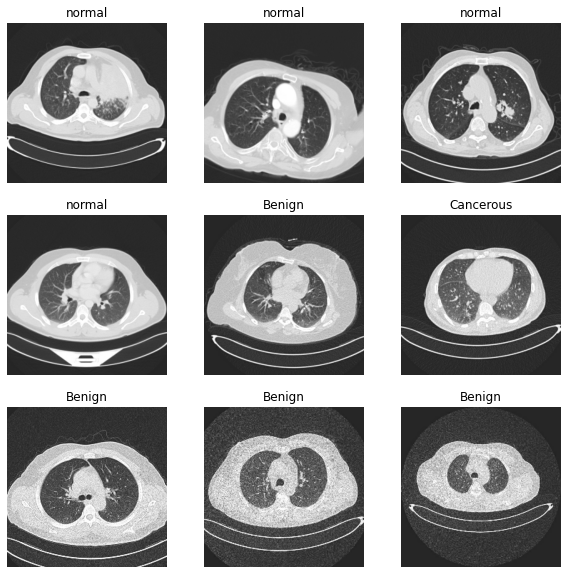

In [47]:
# plotting some examples
# making sure names are being adopted
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names2[labels[i]])
        plt.axis('off')

In [48]:
# importing the same model
base_model2 = keras.applications.MobileNetV3Small(input_shape=(image_width, image_height, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

In [49]:
# freezing layers
base_model2.trainable = False

In [50]:
# some data augmentation 

data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [51]:
num_classes2 = len(class_names2)

inputs = keras.Input(shape=(image_width, image_height, 3))
#x = data_augmentation(inputs)
x2 = keras.applications.mobilenet_v3.preprocess_input(inputs)
x2 = base_model2(x2, training=False)
x2 = keras.layers.GlobalAveragePooling2D()(x2)
x2 = keras.layers.Dropout(0.2)(x2)


outputs = keras.layers.Dense(num_classes2, activation='softmax')(x2) # last layer softmax 
model2 = keras.Model(inputs, outputs)

In [52]:
# compiling model metrics = accuracy
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[METRICS])

In [53]:
# performing 20 epochs at first
initial_epochs = 20

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

# code for training the model over the training data using the validation also
history2 = model2.fit(train_ds2, 
          validation_data=val_ds2,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/20
28/28 [==============================] - 10s 292ms/step - loss: 0.7417 - accuracy: 0.7089 - f1_score: 1.1764 - val_loss: 0.4331 - val_accuracy: 0.8440 - val_f1_score: 1.1007
Epoch 2/20
28/28 [==============================] - 8s 277ms/step - loss: 0.4124 - accuracy: 0.8505 - f1_score: 1.0803 - val_loss: 0.3408 - val_accuracy: 0.8624 - val_f1_score: 1.0233
Epoch 3/20
28/28 [==============================] - 8s 266ms/step - loss: 0.3247 - accuracy: 0.8687 - f1_score: 1.0469 - val_loss: 0.2977 - val_accuracy: 0.8807 - val_f1_score: 1.0125
Epoch 4/20
28/28 [==============================] - 7s 257ms/step - loss: 0.3160 - accuracy: 0.8847 - f1_score: 1.0905 - val_loss: 0.2715 - val_accuracy: 0.8807 - val_f1_score: 0.9725
Epoch 5/20
28/28 [==============================] - 7s 257ms/step - loss: 0.2895 - accuracy: 0.8801 - f1_score: 1.0230 - val_loss: 0.2508 - val_accuracy: 0.8899 - val_f1_score: 1.0004
Epoch 6/20
28/28 [==============================] - 7s 257ms/step - loss: 0.249

early stopping here

In [54]:
# evaluate the model over the unseen data
model2.evaluate(test_ds2)

4/4 [==============================] - 1s 189ms/step - loss: 0.2140 - accuracy: 0.9196 - f1_score: 0.9867


[0.21399109065532684, 0.9196428656578064, 0.9866989850997925]

91% accuracy first trial over the test data, need to redo and take averages

In [37]:
# make a prediction over 1 image

In [96]:
import numpy as np
from keras.preprocessing import image

# loading the image
img = image.load_img('/Users/elliotttrott/Desktop/BenignCTScns/test/Bengin/Bengincase(16).jpg', target_size = (image_width, image_height))
# need to think about the image size and how we are feeding into the model, the model was trained with batches needs some rearrangement before feeding in single image
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

In [49]:
y_prob2 = model2.predict(img)

In [50]:
y_classes = y_prob2.argmax(axis=-1)
y_classes

array([0])

In [51]:
labels = ["Cancerous",
"normal", "Benign"]
predicted_label = np.array(sorted(labels))[y_classes]

In [52]:
predicted_label

array(['Benign'], dtype='<U9')

In [ ]:
# model 2 predicts this case as benign

In [ ]:
# coding for Gabor filter

In [70]:
# necessary imports for Gabor
from PIL import Image, ImageEnhance
import numpy as np
from PIL import ImageFilter
import colorsys
import os
from skimage.filters import gabor, gaussian
from IPython.display import display 
from matplotlib.pyplot import imshow
from pywt import dwt2
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [90]:
# another attempt

# creating function for enhancing brightness, will return an image with brightness set to 0.1 (if it is larger)
def enhance_brightness(image):
    mean_brightness = get_brightness(image)
    a, b = [0.3, 1]
    if mean_brightness<0.1:
        a = 0.1
    min_, max_ = [0, 1]
    new_brightness = (b - a) * (mean_brightness - min_) / (max_ - min_) + a
        
    brightness_factor = new_brightness/mean_brightness
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(brightness_factor)
    return enhanced_image

# will return the mean brightness of image
def get_brightness(image):
    brightness = []
    pixel_values = list(image.getdata())
    for values in pixel_values:
        R, G, B = values
        bright = np.sqrt(0.299 * R ** 2 + 0.587 * G ** 2 + 0.114 * B ** 2) / 255
        brightness.append(bright)
    return np.mean(brightness)

In [91]:
# energy and pixel coding and defining, will return the energy of image
def get_image_energy(pixels):
    _, (cH, cV, cD) = dwt2(pixels.T, 'db1')
    energy = (cH ** 2 + cV ** 2 + cD ** 2).sum() / pixels.size
    return energy

# energy density fixed by size - defining E density
def get_energy_density(pixels):
    energy = get_image_energy(pixels)
    energy_density = energy / (pixels.shape[0]*pixels.shape[1])
    return round(energy_density*100,5) # values are small, therefore, multiply by large number, trialled with 50

In [92]:
# for magnitude and reshaping for PCA
def get_magnitude(response):
    magnitude = np.array([np.sqrt(response[0][i][j]**2+response[1][i][j]**2)
                        for i in range(len(response[0])) for j in range(len(response[0][i]))])
    return magnitude

# reshape to dx1
def apply_pca(array):
    # dimensionality reduction
    standardized_data = StandardScaler().fit_transform(array)
    pca = PCA(n_components=1)
    pca.fit(standardized_data)
    transformed_data = pca.transform(standardized_data)
    return transformed_data

In [94]:
# defining the function that will be called for individual images
def applygabor(image1):
    image = Image.open(image1).convert('RGB')
    image_size = image.size
    print(image_size)
    display(image)
    converter = ImageEnhance.Color(image)
    image = converter.enhance(0.5) # enchancing colour by a factor of X
    image = enhance_brightness(image)
    # conversion to greyscale - images are greyscale from dataset
    image = image.convert('L')
    display(image)
    pixels = np.asarray(image, dtype="int32")
    energy_density = get_energy_density(pixels)
    # fixed bandwidth with energy density - # fixing bandwidth - a large bandwidth should be desireable, may need to change numbers slihhtly here
    bandwidth = abs(0.4*energy_density - 0.5)
    magnitude_dict = {}
    for theta in np.arange(0, np.pi, np.pi / 6):
        for freq in np.array([1.4142135623730951, 2.414213562373095, 2.8284271247461903, 3.414213562373095]): 
            filt_real, filt_imag = gabor(image, frequency=freq, bandwidth=bandwidth, theta=theta)
            # get magnitude response
            magnitude = get_magnitude([filt_real, filt_imag])
            # im = Image.fromarray(magnitude.reshape(image_size)).convert('L')
            # display(im)
            magnitude_dict[(theta, freq)] = magnitude.reshape(image.size)
        # applying gaussian smoothing - gabor is a ix of harmonic function/ multiplied by G fx
    gabor_mag = []
    for key, values in magnitude_dict.items():
        # value of sigma half of applied frequency
        sigma = 0.5*key[1]
        smoothed = gaussian(values, sigma = sigma)
        gabor_mag.append(smoothed)
    gabor_mag = np.array(gabor_mag)

    # reshape so that we can apply PCA
    value = gabor_mag.reshape((-1, image_size[0]*image_size[1]))

    # dimensionally reduced images
    pcaed = apply_pca(value.T).astype(np.uint8)
    result = pcaed.reshape((image_size[0], image_size[1]))
    result_im = Image.fromarray(result, mode='L')
    display(result_im)

(512, 512)


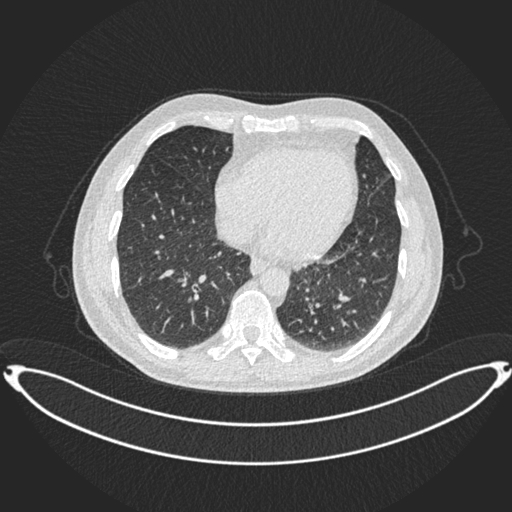

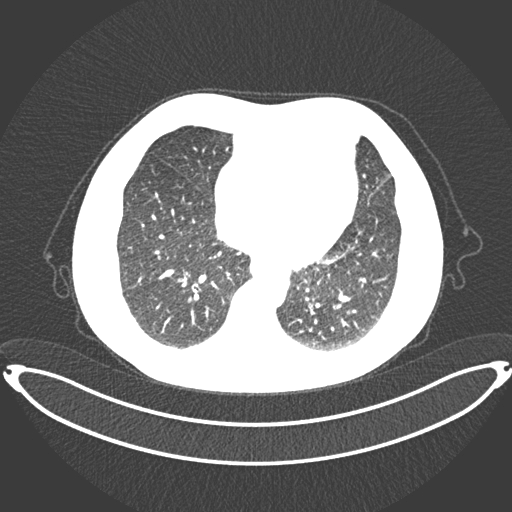

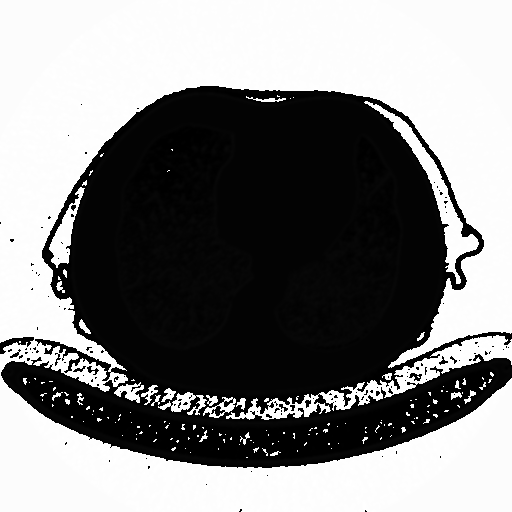

In [95]:
applygabor("/Users/elliotttrott/Desktop/BenignCTScns/train/Bengin/Bengincase(12).jpg")